### Select the best pretrained model

Check the benchamarks of models here and choose an appropriate model based on performance & speed: https://pytorch.org/docs/stable/torchvision/models.html

In [0]:
import torchvision
from torchvision import transforms, datasets

import torch

In [0]:
model = torchvision.models.mobilenet_v2(pretrained=True, progress=True)

In [3]:
torch.cuda.is_available()

True

### Load data and analyse it

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import os

In [6]:
os.listdir("./drive/My Drive/DATASETS/")

['fer2013.tar.gz']

In [0]:
data_dir = "./drive/My Drive/DATASETS/"

In [0]:
import tarfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [9]:
os.listdir(data_dir)

['fer2013.tar.gz']

In [10]:
tar = tarfile.open(data_dir + "/fer2013.tar.gz")
df = pd.read_csv(tar.extractfile("fer2013/fer2013.csv"))
df.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [11]:
df["Usage"].value_counts()

Training       28709
PublicTest      3589
PrivateTest     3589
Name: Usage, dtype: int64

In [12]:
train = df[["emotion", "pixels"]][df["Usage"] == "Training"]
train.head()

,emotion,pixels
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


In [13]:
train['pixels'] = train['pixels'].apply(lambda im: np.fromstring(im, sep=' '))
x_train = np.vstack(train['pixels'].values)
y_train = np.array(train["emotion"])
x_train.shape, y_train.shape

((28709, 2304), (28709,))

In [0]:
test_df = df[["emotion", "pixels"]][df["Usage"]=="PublicTest"]

In [0]:
test_df["pixels"] = test_df["pixels"].apply(lambda im: np.fromstring(im, sep=' '))
x_test = np.vstack(test_df["pixels"].values)
y_test = np.array(test_df["emotion"])

In [16]:
x_train = x_train.reshape(-1, 48, 48, 1)
x_test = x_test.reshape(-1, 48, 48, 1)
x_train.shape, x_test.shape

((28709, 48, 48, 1), (3589, 48, 48, 1))

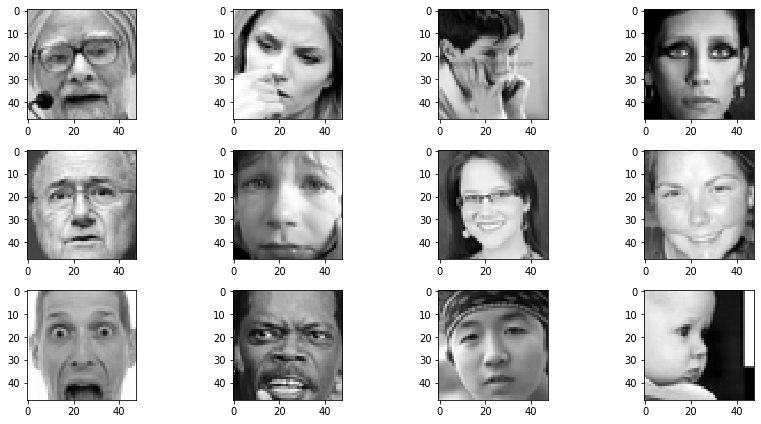

In [17]:
import seaborn as sns
plt.figure(0, figsize=(12,6))
for i in range(1, 13):
    plt.subplot(3,4,i)
    plt.imshow(x_train[i, :, :, 0], cmap="gray")

plt.tight_layout()
plt.show()

In [18]:
y_train

array([0, 0, 2, ..., 4, 0, 4])

In [19]:
y_test

array([0, 1, 4, ..., 4, 4, 4])

### Create dataloaders

In [0]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image

class NumpyDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = torch.LongTensor(labels)
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):

        image = self.images[idx]
        image = np.stack((image.squeeze(-1),)*3, axis=-1)
        image = Image.fromarray(image.astype(np.uint8))

        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)
        
        return image, label

In [0]:
transform = transforms.Compose(
    [
     transforms.ToTensor(),
     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

trainset = NumpyDataset(images=x_train, labels=y_train, transform=transform)

testset = NumpyDataset(images=x_test, labels=y_test, transform=transform)


In [0]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32,
                                          shuffle=True, num_workers=2)

testloader = torch.utils.data.DataLoader(testset, batch_size=32,
                                         shuffle=False, num_workers=2)

In [23]:
classes = list(set(y_train))
classes

[0, 1, 2, 3, 4, 5, 6]

In [0]:
classes_mapping = {
    0:"Angry", 1:"Disgust", 2:"Fear", 3:"Happy", 4:"Sad", 5:"Surprise", 6:"Neutral"
}

In [25]:
dataiter = iter(trainloader)
images, targets = dataiter.next()
images.shape, targets.shape

(torch.Size([32, 3, 48, 48]), torch.Size([32]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


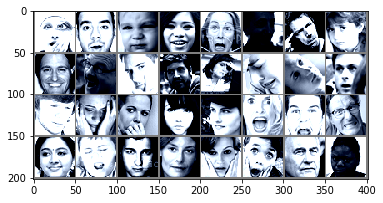

Surprise Surprise Angry Happy  Fear Happy Angry   Sad Happy Happy  Fear Happy Neutral   Sad   Sad  Fear


In [26]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes_mapping[int(labels[j])] for j in range(16)))

### Create loss and optimizer

In [0]:
import torch.optim as optim
from torch import nn

### Replace the final FC layer in model based on the number of classes

In [0]:
model.fc = nn.Linear(in_features=2048, out_features=len(classes), bias=True)

In [29]:
model

MobileNetV2(
  (features): Sequential(
    (0): ConvBNReLU(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=Tr

In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

### Train the model

In [0]:
epochs = 10

In [0]:
from tqdm import tqdm

In [0]:
for epoch in range(epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    for data in tqdm(trainloader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
      
    print('Epoch [%d] loss: %.3f' %
          (epoch + 1, running_loss / len(trainloader)))

print('Finished Training')

  0%|          | 0/898 [00:00<?, ?it/s]

Epoch [1] loss: 1.771


  0%|          | 0/898 [00:00<?, ?it/s]

Epoch [2] loss: 1.239


  0%|          | 0/898 [00:00<?, ?it/s]

Epoch [3] loss: 1.130


 34%|███▍      | 308/898 [03:02<05:48,  1.69it/s]

### Save model

In [0]:
torch.save(model.state_dict(), "model.pth")

### Test

In [0]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))